In [324]:
# !pip uninstall torch-geometric -y
# !pip uninstall torch-scatter -y
# !pip uninstall torch-sparse -y

# Install necessary dependencies
# !pip install torch-scatter 
# !pip install torch-sparse 

# # Install torch-geometric
# !pip install torch-geometric 


In [325]:
from torch_geometric.utils import train_test_split_edges, to_networkx

In [326]:
from torch_geometric.datasets import TUDataset

# Mutag dataset
dataset = TUDataset(root='/tmp/MUTAG', name='MUTAG')

# Total the number of graphs
print(f"Number of graphs in the dataset: {len(dataset)}")

# Access individual graphs
for i, data in enumerate(dataset[:30]):  # analyze first 5 graphs
    print(f"\nGraph {i}:")
    print(f"Number of nodes: {data.num_nodes}")
    print(f"Number of edges: {data.num_edges}")
    print(f"Node feature matrix shape: {data.x.shape}")
    print(f"Edge index shape: {data.edge_index.shape}")
    print(f"Label: {data.y.item()}")

print(len(dataset))


Number of graphs in the dataset: 188

Graph 0:
Number of nodes: 17
Number of edges: 38
Node feature matrix shape: torch.Size([17, 7])
Edge index shape: torch.Size([2, 38])
Label: 1

Graph 1:
Number of nodes: 13
Number of edges: 28
Node feature matrix shape: torch.Size([13, 7])
Edge index shape: torch.Size([2, 28])
Label: 0

Graph 2:
Number of nodes: 13
Number of edges: 28
Node feature matrix shape: torch.Size([13, 7])
Edge index shape: torch.Size([2, 28])
Label: 0

Graph 3:
Number of nodes: 19
Number of edges: 44
Node feature matrix shape: torch.Size([19, 7])
Edge index shape: torch.Size([2, 44])
Label: 1

Graph 4:
Number of nodes: 11
Number of edges: 22
Node feature matrix shape: torch.Size([11, 7])
Edge index shape: torch.Size([2, 22])
Label: 0

Graph 5:
Number of nodes: 28
Number of edges: 62
Node feature matrix shape: torch.Size([28, 7])
Edge index shape: torch.Size([2, 62])
Label: 1

Graph 6:
Number of nodes: 16
Number of edges: 34
Node feature matrix shape: torch.Size([16, 7])
Ed

In [327]:
import torch

# what are the labels?

all_labels = [data.y.item() for data in dataset]  
unique_classes = torch.unique(torch.tensor(all_labels))

print(f"Classes in the dataset: {unique_classes}")
print(f"Number of unique classes: {len(unique_classes)}")


Classes in the dataset: tensor([0, 1])
Number of unique classes: 2


In [328]:
import torch
from torch_geometric.data import DataLoader
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_dense_adj

In [329]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, SAGPooling, global_max_pool
from torch_geometric.utils import to_dense_adj
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv

class GraphEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GraphEncoder, self).__init__()
        self.gat1 = GATConv(in_channels, 2 * out_channels, heads=4)
        self.gat2 = GATConv(8 * out_channels, 2 * out_channels, heads=4)
        self.conv_mu = GATConv(8 * out_channels, out_channels)
        self.conv_logstd = GATConv(8 * out_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # GAT layers to get node-level embeddings
        x = F.elu(self.gat1(x, edge_index))
        x = F.elu(self.gat2(x, edge_index))
        mu = self.conv_mu(x, edge_index)
        logstd = self.conv_logstd(x, edge_index)
        
        # Node-level embeddings
        mu_node = mu  # Node-level mu
        logstd_node = logstd  # Node-level logstd

        # Graph-level embeddings (pooled over nodes)
        mu_graph = global_mean_pool(mu, batch)  # Mean-pooling to get graph-level mu
        logstd_graph = global_mean_pool(logstd, batch)  # Mean-pooling to get graph-level logstd
        
        # Return both node-level and graph-level embeddings
        return mu_node, logstd_node, mu_graph, logstd_graph



In [392]:
# DECODER SHOULD BE PREDICTING 1) Node feature 2) Edge 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv



class AttentionAggregator(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionAggregator, self).__init__()
        self.attention_weights = nn.Linear(hidden_dim, 1)

    def forward(self, node_features):
        # Ensure the input node features have the correct shape
        # node_features should be of shape (num_nodes, hidden_dim)
        attn_scores = self.attention_weights(node_features)  # Shape: (num_nodes, 1)
        attn_weights = torch.softmax(attn_scores, dim=0)  # Shape: (num_nodes, 1)
        
        # Aggregate node features using attention weights
        aggregated = torch.matmul(attn_weights.T, node_features)  # Shape: (1, hidden_dim)
        print("This is original aggregated shape: ", aggregated.shape)
        return aggregated.squeeze(0)  # Return the aggregated feature vector


class GraphDecoder(nn.Module):
    def __init__(self, node_latent_dim, graph_latent_dim, hidden_dim, node_feature_dim):
        """
        Decoder for graph reconstruction from both node-level and graph-level latent embeddings.

        Args:
            node_latent_dim (int): Dimension of the node-level latent embedding.
            graph_latent_dim (int): Dimension of the graph-level latent embedding.
            hidden_dim (int): Dimension of the hidden layers.
            node_feature_dim (int): The dimension of the node features to reconstruct.
        """
        super(GraphDecoder, self).__init__()
        self.hidden_dim = hidden_dim

        # Linear transformation for node-level embedding to hidden layer
        self.node_init = nn.Linear(node_latent_dim, hidden_dim)

        # GCN layers to process node-level embeddings with true edge_index during training
        self.gcn1 = GCNConv(hidden_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)

        # Output layer for adjacency matrix prediction (edge prediction layer)
        self.edge_pred = nn.Linear(2 * hidden_dim + graph_latent_dim, 1)  # Combine node embeddings + graph embedding

        # Output layer for node feature prediction
        self.node_feat_output = nn.Linear(hidden_dim, node_feature_dim)

        # Initialize attention aggregator
        self.aggregator = AttentionAggregator(node_feature_dim)

        # Node-to-graph projection layer
        self.node_to_graph_proj = nn.Linear(node_feature_dim, graph_latent_dim)

    def forward(self, node_latent, graph_latent, num_nodes, edge_index):
        # Step 1: Generate node embeddings from the latent vector
        node_embeddings = self.node_init(node_latent)  # Shape: (num_nodes, hidden_dim)

        # Step 2: Process node embeddings through GCN layers with the true edge index
        x = F.relu(self.gcn1(node_embeddings, edge_index))
        x = F.relu(self.gcn2(x, edge_index))

        # Step 3: Predict node features
        node_features_pred = self.node_feat_output(x)

        # Step 4: Initialize predicted adjacency matrix (num_nodes, num_nodes)
        adj_pred = torch.zeros(num_nodes, num_nodes)  # Initialize the adjacency matrix

        # Expand graph latent embedding for each node pair
        graph_latent_expanded = graph_latent.unsqueeze(0).repeat(num_nodes, 1)

        # Step 5: Predict node-to-graph embedding
        node_to_graph_pred = self.node_to_graph_proj(node_features_pred)  # Shape: (num_nodes, graph_latent_dim)

        # Predict edges between node pairs
        for i in range(num_nodes):
            for j in range(i + 1, num_nodes):
                # Combine node features and graph latent embedding for edge prediction
                edge_input = torch.cat([node_features_pred[i], node_features_pred[j], graph_latent], dim=-1)

                # Predict edge probability
                edge_prob = torch.sigmoid(self.edge_pred(edge_input))

                # Assign edge probability to the adjacency matrix
                adj_pred[i, j] = edge_prob
                adj_pred[j, i] = edge_prob  # Symmetric for undirected graphs

        # Concatenate the node-to-graph embeddings with the graph latent embedding
        final_representation = torch.cat([node_to_graph_pred, graph_latent_expanded], dim=-1)  # Shape: (num_nodes, 2 * graph_latent_dim)

        # Optionally apply a final linear layer
        adj_pred = self.final_linear_layer(final_representation)

        return adj_pred, node_features_pred


    # def forward(self, node_latent, graph_latent, num_nodes, edge_index):
    #     """
    #     Forward pass for decoding the graph from both node and graph latent embeddings.

    #     Args:
    #         node_latent (torch.Tensor): Latent representation for nodes (num_nodes, node_latent_dim).
    #         graph_latent (torch.Tensor): Latent representation for the graph (graph_latent_dim).
    #         num_nodes (int): Number of nodes in the current graph.
    #         edge_index (torch.Tensor): Edge index for message passing in GCN layers.

    #     Returns:
    #         adj_pred (torch.Tensor): Predicted adjacency matrix.
    #         node_features_pred (torch.Tensor): Predicted node features.
    #     """
    #     # Step 1: Generate node embeddings from the latent vector
    #     node_embeddings = self.node_init(node_latent)  # Shape: (num_nodes, hidden_dim)

    #     # Step 2: Process node embeddings through GCN layers with the true edge index (for message passing)
    #     x = F.relu(self.gcn1(node_embeddings, edge_index))
    #     x = F.relu(self.gcn2(x, edge_index))

    #     # Step 3: Predict node features
    #     node_features_pred = self.node_feat_output(x)
    #     print("This is node_features_pred:", node_features_pred)
    #     print("This is node_feature_pred shape:", node_features_pred.shape)
    #     # Step 4: Use predicted node features for edge prediction
    #     adj_pred = torch.zeros(num_nodes, num_nodes)  # Initialize predicted adjacency matrix

    #     # Expand graph latent embedding (edge prediction) for each node pair
    #     graph_latent_expanded = graph_latent.unsqueeze(0).repeat(num_nodes, 1)
    #     print("This is graph latent_expanded:", graph_latent_expanded)
    #     print("This is graph latent_expanded SHAPE:", graph_latent_expanded.shape)
    #     print("number of node:", num_nodes)

    #     node_to_graph_pred = self.node_to_graph_proj(node_features_pred)  # Shape: (num_nodes, graph_latent_dim)
    #     print("node_to_graph_pred SHAPE:", node_to_graph_pred.shape)
    #     for i in range(num_nodes):
    #         for j in range(i + 1, num_nodes):
    #             # Combine node features and predict edge
    #             edge_input = torch.cat([node_features_pred[i], node_features_pred[j]], dim=-1)
    #             edge_prob = torch.sigmoid(self.edge_pred(edge_input))
                
    #             # Assign edge probability to adjacency matrix
    #             node_to_graph_pred[i, j] = edge_prob
    #             node_to_graph_pred[j, i] = edge_prob  # Symmetric for undirected graph

    #     print("graph_latent_expanded SHAPEEEE:", graph_latent_expanded.shape)
    #     print("node_to_graph_pred SHAPPEEE:", node_to_graph_pred.shape)
    #     adj_pred = torch.cat([graph_latent_expanded, node_to_graph_pred], dim=-1)  # Shape: (num_nodes, 2 * graph_latent_dim)
    #     adj_pred = self.final_linear_layer(adj_pred)  # Optionally apply linear transformation

    #     return adj_pred
    

# edge_input shape: torch.Size([15])
# graph_latent_expanded[i] shape: torch.Size([8])


In [393]:
a = torch.rand(1, 3, 4)
print(a.shape)
b = torch.rand(3, 4)
print("this is b1:", b)
print(b.shape)
b = b.unsqueeze(0)
print("this is b2:", b)
print(b.shape)
c = torch.cat([a, b], dim=0)
print(c.shape)

torch.Size([1, 3, 4])
this is b1: tensor([[0.6738, 0.6735, 0.5750, 0.4161],
        [0.2003, 0.4666, 0.8447, 0.0130],
        [0.7910, 0.7648, 0.5700, 0.2391]])
torch.Size([3, 4])
this is b2: tensor([[[0.6738, 0.6735, 0.5750, 0.4161],
         [0.2003, 0.4666, 0.8447, 0.0130],
         [0.7910, 0.7648, 0.5700, 0.2391]]])
torch.Size([1, 3, 4])
torch.Size([2, 3, 4])


In [394]:
# # Treat adjacency matrix reconstruction as a binary classification task (edge exists or not).
# # Use Binary Cross-Entropy (BCE) for the reconstruction loss
# Loss function for node feature reconstruction and edge prediction

def vae_loss(adj_true, adj_pred, node_features_true, node_features_pred):
    """
    Compute combined loss for node feature reconstruction and adjacency matrix prediction.

    Args:
        adj_true (torch.Tensor): Ground truth adjacency matrix.
        adj_pred (torch.Tensor): Predicted adjacency matrix.
        node_features_true (torch.Tensor): Ground truth node features.
        node_features_pred (torch.Tensor): Predicted node features.

    Returns:
        total_loss (torch.Tensor): Combined loss.
    """
    # Node feature reconstruction loss (e.g., MSE loss)
    node_loss = F.mse_loss(node_features_pred, node_features_true)

    # Adjacency matrix prediction loss (e.g., binary cross-entropy loss)
    adj_loss = F.binary_cross_entropy(adj_pred, adj_true)

    # Combine the two losses
    total_loss = node_loss + adj_loss

    return total_loss




In [395]:
import matplotlib.pyplot as plt

def plot_adjacency_matrices(adj_true, adj_pred, epoch, graph_idx, phase="Train"):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot the true adjacency matrix
    ax = axes[0]
    ax.imshow(adj_true.cpu().detach().numpy(), cmap="Blues", aspect='auto')
    ax.set_title(f"{phase} True Adjacency Matrix - Graph {graph_idx}")
    
    # Plot the predicted adjacency matrix
    ax = axes[1]
    ax.imshow(adj_pred.cpu().detach().numpy(), cmap="Reds", aspect='auto')
    ax.set_title(f"{phase} Predicted Adjacency Matrix - Graph {graph_idx}")

    plt.suptitle(f"{phase} Epoch {epoch} - Graph {graph_idx}")
    plt.show()

In [396]:
'''
Need to update the training process
Will have to consider the node feature prediction --> edge prediction ; the hierarchical process 
Last change in decoder : allow decoder to predict both on node level and edge level ; needed encoder change accordingly to pass in both... 
'''
def train(loader, epoch):
    encoder.train()
    decoder.train()
    total_loss = 0

    for batch_idx, data in enumerate(loader):
        optimizer.zero_grad()

        # Encode the graph into a latent representation
        mu_node, logstd_node, mu_graph, logstd_graph = encoder(data.x, data.edge_index, data.batch)
        
        # Reparameterization trick for node-level and graph-level embeddings
        z_node = mu_node + torch.randn_like(mu_node) * torch.exp(logstd_node)  # Node-level latent z
        z_graph = mu_graph + torch.randn_like(mu_graph) * torch.exp(logstd_graph)  # Graph-level latent z

        batch_loss = 0
        for i in range(data.num_graphs):
            num_nodes = (data.batch == i).sum().item()  # Number of nodes in the ith graph
            if num_nodes == 0:
                continue  # Skip empty graphs

            # Filter edges for the current graph
            mask = (data.batch[data.edge_index[0]] == i) & (data.batch[data.edge_index[1]] == i)
            valid_edges = data.edge_index[:, mask]

            # Reindex nodes
            node_mask = (data.batch == i).nonzero(as_tuple=False).squeeze()
            node_map = {node.item(): idx for idx, node in enumerate(node_mask)}
            reindexed_edges = valid_edges.clone()
            reindexed_edges[0] = valid_edges[0].apply_(lambda x: node_map[x])
            reindexed_edges[1] = valid_edges[1].apply_(lambda x: node_map[x])

            # Convert to dense adjacency matrix
            edge_true = to_dense_adj(reindexed_edges, max_num_nodes=num_nodes).squeeze(0)

            # Extract true node features for the current graph
            node_true = data.x[node_mask]  # Ground truth node features for the current graph

            # Decode both the adjacency matrix and node features using the decoder's forward method
            edge_pred, node_pred = decoder(z_node[node_mask], z_graph[i], num_nodes, reindexed_edges)

            # Ensure adjacency matrices match
            edge_pred = edge_pred[:num_nodes, :num_nodes]
            edge_true = edge_true[:num_nodes, :num_nodes]

            if batch_idx == 0 and epoch % 10 == 0:  # Plot for the first batch every 10 epochs
                plot_adjacency_matrices(edge_true, edge_pred, epoch, i, phase="Train")

            # Compute the VAE loss (node feature loss + edge loss)
            loss = vae_loss(edge_true, edge_pred, node_true, node_pred)
            batch_loss += loss

        # Backpropagation
        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item()
    
    return total_loss / len(loader)


In [397]:
def validate(loader, epoch):
    encoder.eval()  # Set encoder to evaluation mode
    decoder.eval()  # Set decoder to evaluation mode
    total_loss = 0

    with torch.no_grad():  # Disable gradient computation
        for batch_idx, data in enumerate(loader):
            # Encode the graph into a latent representation
            mu, logstd = encoder(data.x, data.edge_index, data.batch)
            z = mu + torch.randn_like(mu) * torch.exp(logstd) # need to Skip reparameterization (use mean during validation)??

            batch_loss = 0
            for i in range(data.num_graphs):
                num_nodes = (data.batch == i).sum().item()  # Number of nodes in the ith graph
                if num_nodes == 0:
                    continue  # Skip empty graphs

                # Filter edges for the current graph
                mask = (data.batch[data.edge_index[0]] == i) & (data.batch[data.edge_index[1]] == i)
                valid_edges = data.edge_index[:, mask]

                # Reindex nodes
                node_mask = (data.batch == i).nonzero(as_tuple=False).squeeze()
                node_map = {node.item(): idx for idx, node in enumerate(node_mask)}
                reindexed_edges = valid_edges.clone()
                reindexed_edges[0] = valid_edges[0].apply_(lambda x: node_map[x])
                reindexed_edges[1] = valid_edges[1].apply_(lambda x: node_map[x])

                # Convert to dense adjacency matrix
                adj_true = to_dense_adj(reindexed_edges, max_num_nodes=num_nodes).squeeze(0)

                # Ensure that the latent code z[i] is expanded to (num_nodes, input_dim)
                z_i = z[i].unsqueeze(0).repeat(num_nodes, 1)  # Repeat z[i] for each node

                # Decode adjacency matrix
                adj_pred = decoder(z_i, num_nodes)

                # Ensure adjacency matrices match
                adj_pred = adj_pred[:num_nodes, :num_nodes]
                adj_true = adj_true[:num_nodes, :num_nodes]

                if batch_idx == 10 and epoch % 20 == 0:  # Plot for the first batch every 10 epochs
                    plot_adjacency_matrices(adj_true, adj_pred, epoch, i, phase="Train")


                # Compute loss
                loss = vae_loss(adj_true, adj_pred, mu[i], logstd[i]) / num_nodes # Normalize Loss by Graph Size
                # print(f"VAL, Unnormalized Loss: {loss.item()*num_nodes:.4f}, num_nodes = {num_nodes}")
                # print(f"VAL, Normalized Loss: {loss.item():.4f}")
                batch_loss += loss

            total_loss += batch_loss.item()
        return total_loss / len(loader)  # Average loss over the loader


In [398]:
# Load dataset and initialize model, optimizer, etc.
dataset = TUDataset(root='/tmp/MUTAG', name='MUTAG')

# Split dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [399]:
# Initialize encoder and decoder
encoder = GraphEncoder(in_channels=dataset.num_features, out_channels=8) ## PERHAPS CAN IMPROVE TO HAVE DIFF DIM FOR NODE AND EDGE EMBEDDING 

# Assuming the latent dimension for nodes is 8 and for the graph-level latent is also 8.
node_latent_dim = 8  # Output dimension for node-level embeddings from encoder
graph_latent_dim = 8  # Output dimension for graph-level embeddings from encoder (pooled version)
hidden_dim = 32  # Hidden layer dimension for the decoder
node_feature_dim = dataset.num_features  # Assuming this is the feature dimension of the nodes

decoder = GraphDecoder(node_latent_dim=node_latent_dim, 
                       graph_latent_dim=graph_latent_dim, 
                       hidden_dim=hidden_dim, 
                       node_feature_dim=node_feature_dim)

# Initialize optimizer
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-5)


In [400]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    """
    Plots the training and validation losses over epochs.

    Args:
        train_losses (list): List of training losses for each epoch.
        val_losses (list): List of validation losses for each epoch.
    """
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_losses) + 1)  # Epoch numbers start at 1

    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='orange')

    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [401]:
# Lists to store losses
train_losses = []
val_losses = []


epochs = 100
for epoch in range(epochs):
    # Train for one epoch
    train_loss = train(train_loader, epoch)
    train_losses.append(train_loss)

    # Validate for one epoch
    val_loss = validate(val_loader, epoch)
    val_losses.append(val_loss)

    # Print epoch progress
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

print("train_losses:",train_losses)
print("val_losses:", val_losses)
plot_losses(train_losses, val_losses)




RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x22 and 72x1)

In [391]:
# import matplotlib.pyplot as plt
# import networkx as nx

# true_graph = nx.from_numpy_array(adj_true.cpu().numpy())
# pred_graph = nx.from_numpy_array(adj_pred.cpu().detach().numpy() > 0.5)  # Threshold for edges

# plt.figure(figsize=(10, 5))
# plt.subplot(121)
# nx.draw(true_graph, with_labels=True)
# plt.title("True Graph")

# plt.subplot(122)
# nx.draw(pred_graph, with_labels=True)
# plt.title("Predicted Graph")
# plt.show()


### visualization

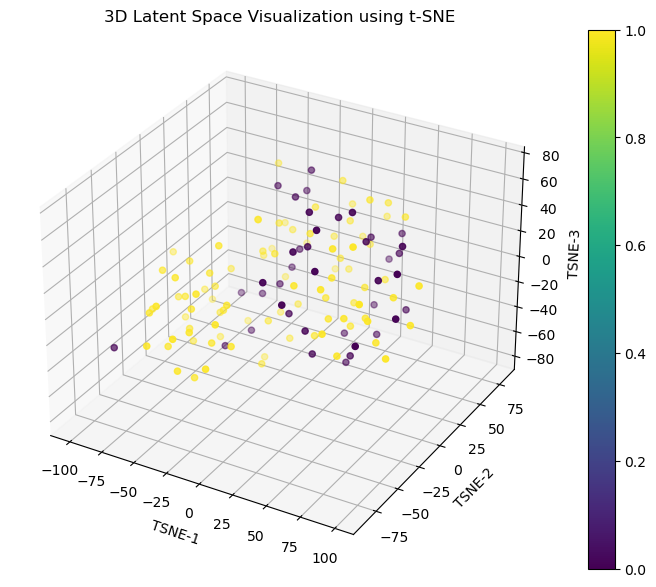

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


# Function to extract latent space from encoder
def extract_latent_space(encoder, dataloader):
    encoder.eval()  # Set encoder to evaluation mode
    latent_representations = []
    labels = []
    
    with torch.no_grad():
        for data in dataloader:
            x, edge_index, batch = data.x, data.edge_index, data.batch
            # Encode and get the latent space (mean 'mu' from encoder)
            mu, logstd = encoder(x, edge_index, batch)  # Adjust based on encoder output
            latent_representations.append(mu.detach().cpu().numpy())
            labels.append(data.y.cpu().numpy())  # labels in dataset

    latent_representations = np.concatenate(latent_representations, axis=0)
    labels = np.concatenate(labels, axis=0)  # Use this if you want to color by label class
    return latent_representations, labels

# Extract latent space representations from the trained encoder
latent_space, labels = extract_latent_space(encoder, train_loader)

# Apply t-SNE for dimensionality reduction to 3D
tsne = TSNE(n_components=3, random_state=42)
latent_space_3d = tsne.fit_transform(latent_space)

# Plot the 3D latent space
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
scatter = ax.scatter(latent_space_3d[:, 0], latent_space_3d[:, 1], latent_space_3d[:, 2], c=labels, cmap='viridis', marker='o')

# Add labels and title
ax.set_xlabel('TSNE-1')
ax.set_ylabel('TSNE-2')
ax.set_zlabel('TSNE-3')
ax.set_title('3D Latent Space Visualization using t-SNE')

# Add colorbar if you have labels to color by
plt.colorbar(scatter)

plt.show()


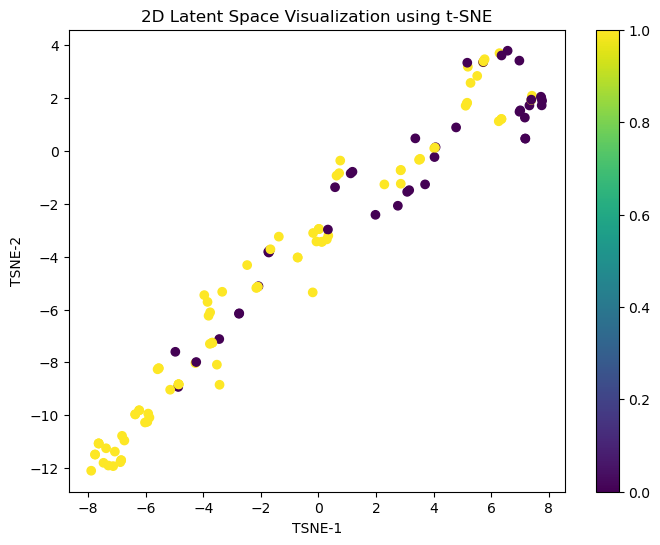

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np


# Function to extract latent space from encoder
def extract_latent_space(encoder, dataloader):
    encoder.eval()  # Set encoder to evaluation mode
    latent_representations = []
    labels = []
    
    with torch.no_grad():
        for data in dataloader:
            x, edge_index, batch = data.x, data.edge_index, data.batch
            # Encode and get the latent space (mean 'mu' from encoder)
            mu, logstd = encoder(x, edge_index, batch)  # Adjust based on encoder output
            latent_representations.append(mu.detach().cpu().numpy())
            labels.append(data.y.cpu().numpy())  # labels in dataset

    latent_representations = np.concatenate(latent_representations, axis=0)
    labels = np.concatenate(labels, axis=0)  # Use this if you want to color by label class
    return latent_representations, labels

# Extract latent space representations from the trained encoder
latent_space, labels = extract_latent_space(encoder, train_loader)

# Apply t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42)
latent_space_2d = tsne.fit_transform(latent_space)

# Plot the 2D latent space
plt.figure(figsize=(8, 6))
plt.scatter(latent_space_2d[:, 0], latent_space_2d[:, 1], c=labels, cmap='viridis', marker='o')

# Add labels and title
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.title('2D Latent Space Visualization using t-SNE')

# Add colorbar if you have labels to color by
plt.colorbar()

plt.show()


In [ ]:
import torch
import torch.nn.functional as F

# Provided tensors
adj_pred = torch.tensor([[0.9963, 0.9958, 0.9906, 0.9933, 0.9890, 0.9895, 0.9632, 0.9936, 0.9928, 0.9960, 0.9769, 0.9965, 0.9956, 0.9727, 0.9972],
                         [0.9958, 0.9980, 0.9939, 0.9932, 0.9909, 0.9915, 0.9497, 0.9941, 0.9955, 0.9964, 0.9752, 0.9983, 0.9962, 0.9712, 0.9983],
                         [0.9906, 0.9939, 0.9917, 0.9919, 0.9855, 0.9849, 0.9512, 0.9920, 0.9925, 0.9916, 0.9651, 0.9943, 0.9919, 0.9598, 0.9955],
                         [0.9933, 0.9932, 0.9919, 0.9954, 0.9893, 0.9869, 0.9679, 0.9934, 0.9922, 0.9927, 0.9738, 0.9938, 0.9934, 0.9665, 0.9955],
                         [0.9890, 0.9909, 0.9855, 0.9893, 0.9859, 0.9814, 0.9551, 0.9891, 0.9886, 0.9896, 0.9616, 0.9921, 0.9894, 0.9607, 0.9927],
                         [0.9895, 0.9915, 0.9849, 0.9869, 0.9814, 0.9824, 0.9481, 0.9881, 0.9869, 0.9902, 0.9631, 0.9929, 0.9901, 0.9589, 0.9934],
                         [0.9632, 0.9497, 0.9512, 0.9679, 0.9551, 0.9481, 0.9372, 0.9686, 0.9529, 0.9642, 0.9286, 0.9550, 0.9608, 0.9274, 0.9639],
                         [0.9936, 0.9941, 0.9920, 0.9934, 0.9891, 0.9881, 0.9686, 0.9952, 0.9937, 0.9948, 0.9698, 0.9949, 0.9931, 0.9712, 0.9961],
                         [0.9928, 0.9955, 0.9925, 0.9922, 0.9886, 0.9869, 0.9529, 0.9937, 0.9946, 0.9940, 0.9652, 0.9959, 0.9935, 0.9660, 0.9966],
                         [0.9960, 0.9964, 0.9916, 0.9927, 0.9896, 0.9902, 0.9642, 0.9948, 0.9940, 0.9969, 0.9747, 0.9970, 0.9950, 0.9742, 0.9976],
                         [0.9769, 0.9752, 0.9651, 0.9738, 0.9616, 0.9631, 0.9286, 0.9698, 0.9652, 0.9747, 0.9535, 0.9784, 0.9777, 0.9408, 0.9816],
                         [0.9965, 0.9983, 0.9943, 0.9938, 0.9921, 0.9929, 0.9550, 0.9949, 0.9959, 0.9970, 0.9784, 0.9987, 0.9967, 0.9749, 0.9986],
                         [0.9956, 0.9962, 0.9919, 0.9934, 0.9894, 0.9901, 0.9608, 0.9931, 0.9935, 0.9950, 0.9777, 0.9967, 0.9963, 0.9743, 0.9971],
                         [0.9727, 0.9712, 0.9598, 0.9665, 0.9607, 0.9589, 0.9274, 0.9712, 0.9660, 0.9742, 0.9408, 0.9749, 0.9743, 0.9426, 0.9774],
                         [0.9972, 0.9983, 0.9955, 0.9955, 0.9927, 0.9934, 0.9639, 0.9961, 0.9966, 0.9976, 0.9816, 0.9986, 0.9971, 0.9774, 0.9988]])
print(adj_pred.shape)


adj_true = torch.tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
                         [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                         [0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
                         [0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
                         [0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
                         [0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
                         [0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
                         [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.],
                         [0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
                         [1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
                         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.],
                         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
                         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
                         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
                         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])
print(adj_true.shape)

# BCE Loss Calculation
loss1 = F.binary_cross_entropy(adj_true, adj_pred)
print(loss1.item())

loss2 = F.binary_cross_entropy(adj_pred,adj_true)
print(loss2.item())


loss_fn = nn.BCEWithLogitsLoss()
# Calculate BCE loss
loss3 = loss_fn(adj_true, adj_pred)

print("Binary Cross-Entropy Loss3:", loss3.item())

torch.Size([15, 15])
torch.Size([15, 15])
83.6541748046875
3.818040132522583
Binary Cross-Entropy Loss3: 0.6384369730949402


In [ ]:
import torch
import torch.nn.functional as F

# Provided tensors
adj_pred = torch.tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
print(adj_pred.shape)
adj_true = torch.tensor([[0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])
print(adj_true.shape)

# BCE Loss Calculation
loss = F.binary_cross_entropy(adj_true, adj_pred)
print(loss.item())



# Loss function
loss_fn = nn.BCEWithLogitsLoss()

# Calculate BCE loss
loss3 = loss_fn(adj_true, adj_pred)

print("Binary Cross-Entropy Loss3:", loss3.item())

torch.Size([16, 16])
torch.Size([16, 16])
86.71875
Binary Cross-Entropy Loss3: 0.6426936388015747
